In [2]:
#!c1.8
%cd dla/hw2_kws

/home/jupyter/work/resources/dla/hw2_kws


Этот нотбук является копией основного и использовался в основном в секции 5 (Model 5) для супер метода, остальные части практическ

In [1]:
#!c1.8
print(123)

123


In [337]:
#!c1.8
!git clone https://github.com/markovka17/dla

Cloning into 'dla'...


# Import and misc

In [65]:
#!c1.8
%pip install torch==1.11.0+cu102 torchvision==0.12.0+cu102 torchaudio==0.11.0+cu102 --extra-index-url https://download.pytorch.org/whl/cu102

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu102
     |████████████████████████████████| 750.6 MB 5.9 kB/s              
     |████████████████████████████████| 21.0 MB 78.7 MB/s            
     |████████████████████████████████| 2.9 MB 2.2 MB/s            
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1+cu111
    Uninstalling torch-1.9.1+cu111:
      Successfully uninstalled torch-1.9.1+cu111
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1+cu111
    Uninstalling torchvision-0.10.1+cu111:
      Successfully uninstalled torchvision-0.10.1+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.9.1
    Uninstalling torchaudio-0.9.1:
      Successfully uninstalled to

In [ ]:
# Instal latest torch and torchaudio

In [1]:
#!c1.8
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses
import random

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [3]:
#!c1.8
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [341]:
#!c1.8
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

.... 77%  175M 4s
1129600K .......... .......... .......... .......... .......... 77% 89.8M 4s
1129650K .......... .......... .......... .......... .......... 77%  149M 4s
1129700K .......... .......... .......... .......... .......... 77%  386M 4s
1129750K .......... .......... .......... .......... .......... 77%  494M 4s
1129800K .......... .......... .......... .......... .......... 77%  195M 4s
1129850K .......... .......... .......... .......... .......... 77%  186M 4s
1129900K .......... .......... .......... .......... .......... 77%  262M 4s
1129950K .......... .......... .......... .......... .......... 77% 90.5M 4s
1130000K .......... .......... .......... .......... .......... 77%  495M 4s
1130050K .......... .......... .......... .......... .......... 77%  113M 4s
1130100K .......... .......... .......... .......... .......... 77%  525M 4s
1130150K .......... .......... .......... .......... .......... 77%  472M 4s
1130200K .......... .......... .......... .......... .....

In [4]:
#!c1.8
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [5]:
#!c1.8
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [6]:
#!c1.8
dataset.csv.sample(5)

,path,keyword,label
35608,speech_commands/two/4d4e17f5_nohash_0.wav,two,0
1268,speech_commands/eight/92a9c5e6_nohash_3.wav,eight,0
6054,speech_commands/nine/130d9a87_nohash_1.wav,nine,0
28768,speech_commands/marvin/016e2c6d_nohash_2.wav,marvin,0
8206,speech_commands/yes/7211390b_nohash_1.wav,yes,0


### Augmentations

In [7]:
#!c1.8
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [8]:
#!c1.8
setup_seed(42)
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [9]:
#!c1.8
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [10]:
#!c1.8
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [11]:
#!c1.8
train_sampler = get_sampler(train_set.csv['label'].values)

In [12]:
#!c1.8
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [13]:
#!c1.8
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=8, pin_memory=True, drop_last=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=8, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [14]:
#!c1.8
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [15]:
#!c1.8
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [16]:
#!c1.8
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [17]:
#!c1.8
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [18]:
#!c1.8
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [19]:
#!c1.8
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [20]:
#!c1.8
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [21]:
#!c1.8
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [22]:
#!c1.8
config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [23]:
#!c1.8
sum([p.numel() for p in model.parameters()])

25387

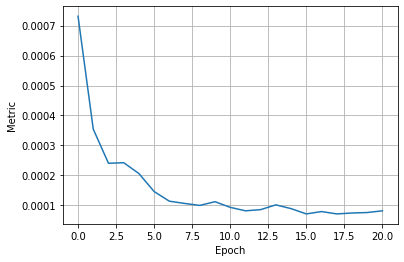

8.14122678754531e-05
END OF EPOCH 0


 10%|▉         | 40/405 [00:04<00:38,  9.60it/s]


KeyboardInterrupt: 

In [366]:
#!c1.8
# TRAIN
best_score = 100
for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        state = model.state_dict()
        torch.save(state, 'model.pt')
        
    print(best_score)
    print('END OF EPOCH', n)

In [151]:
#!c1.8
#save_dict = model.state_dict()
#torch.save(save_dict, 'baseline.pt')

In [365]:
#!c1.8
history

defaultdict(list,
            {'val_metric': [0.0007314154530539746,
              0.00035420378667747987,
              0.00024022362787805496,
              0.0002421690483895006,
              0.00020596393721483515,
              0.00014582299269229042,
              0.00011359823575423312,
              0.00010606719070685749,
              9.949692082004249e-05,
              0.00011188554959845119,
              9.300422905178206e-05,
              8.14271867444059e-05,
              8.540754098101411e-05,
              0.00010135879566535245,
              8.867477328167823e-05,
              7.107349169115973e-05,
              7.890888166517253e-05,
              7.109736188148421e-05,
              7.405129793413948e-05,
              7.572817880443466e-05]})

In [367]:
#!c1.8
ckpt = torch.load('baseline.pt')
model.load_state_dict(ckpt)

<All keys matched successfully>

In [368]:
#!c1.8
validation(model, val_loader, melspec_val, config.device)

102it [00:10,  9.51it/s]


2.2372335881625337e-05

# Base metrics

In [24]:
#!c1.8
import time


class Timer:

    def __init__(self, name: str, verbose=False):
        self.name = name
        self.verbose = verbose

    def __enter__(self):
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self.t = time.time() - self.t

        if self.verbose:
            print(f"{self.name.capitalize()} | Elapsed time : {self.t:.2f}")

In [25]:
#!c1.8
from thop import profile  

batch, labels = next(train_loader.__iter__())
#batch, labels = batch.to('cuda:0'), labels.to('cuda:0')
batch = melspec_train(batch)
profile(model, (batch, ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


(55382016.0, 25387.0)

In [26]:
#!c1.8
MACS_CNT = 55382016.0

In [27]:
#!c1.8
import tempfile

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

In [28]:
#!c1.8
SIZE = get_size_in_megabytes(model)
SIZE

0.10348224639892578

# Distilation

In [464]:
#!c1.8
def train_dist_epoch(teacher, student, opt, loader, log_melspec, device, temp):
    student.train()
    teacher.eval()
    
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        with torch.no_grad():
            logits_teach = teacher(batch) / temp
            probs_teach = F.softmax(logits_teach, dim=-1)
        logits_stud = student(batch) / temp
        log_probs_stud = F.log_softmax(logits_stud, dim=-1)
        
        loss1 = F.kl_div(log_probs_stud, probs_teach, log_target=False)
        loss2 = F.cross_entropy(logits_stud, labels)
        
        loss = loss1 + loss2

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(log_probs_stud, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [63]:
#!c1.8
config_stud = TaskConfig(cnn_out_channels=3, hidden_size = 28, gru_num_layers = 2)
student = CRNN(config_stud).cuda()

In [64]:
#!c1.8
get_size_in_megabytes(student) / SIZE

0.5222205665965095

In [65]:
#!c1.8
macs, _ = profile(student, (batch, ))
macs / MACS_CNT

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


0.47127616300569486

In [66]:
#!c1.8
opt = torch.optim.Adam(
    student.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
sum([p.numel() for p in student.parameters()])

13130

In [67]:
#!c1.8
history = defaultdict(list)
for n in range(TaskConfig.num_epochs):

    train_dist_epoch(model, student, opt, train_loader,
                melspec_train, config_stud.device, 7)

    au_fa_fr = validation(student, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

100%|██████████| 405/405 [00:21<00:00, 18.75it/s]
0it [00:00, ?it/s]


KeyboardInterrupt: 

In [ ]:
#!c1.8
shedulder = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=3e-3, epochs=15, steps_per_epoch=len(train_loader), pct_start=3/15)

## Model 2

In [74]:
#!g1.1
config_stud = TaskConfig(cnn_out_channels=3, hidden_size = 14, gru_num_layers = 2)
student = CRNN(config_stud).cuda()
print('size rate', SIZE / get_size_in_megabytes(student))
macs, _ = profile(student, (batch, ))
print('macs rate', MACS_CNT / macs )

size rate 4.750608326328363
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
macs rate 3.930023434519592


In [75]:
#!g1.1
opt = torch.optim.Adam(
    student.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
sum([p.numel() for p in student.parameters()])

4758

END OF EPOCH 16


 14%|█▍        | 56/405 [00:06<00:39,  8.85it/s]


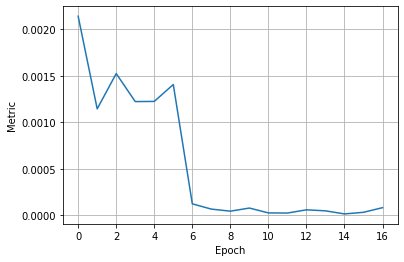

KeyboardInterrupt: 

In [72]:
#!g1.1
history = defaultdict(list)
best_score = 100
best_epoch = 0 
for n in range(TaskConfig.num_epochs):

    train_dist_epoch(model, student, opt, train_loader,
                melspec_train, config_stud.device, 7)

    au_fa_fr = validation(student, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)

# Model 3

In [113]:
#!g1.1
config_stud = TaskConfig(cnn_out_channels=3, hidden_size = 10, gru_num_layers = 2, stride=(3, 10))
student = CRNN(config_stud).cuda()
print('size rate', SIZE / get_size_in_megabytes(student))
macs, _ = profile(student, (batch, ))
print('macs rate', MACS_CNT / macs )
_ = student(batch)

size rate 7.761329960245754
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
macs rate 8.07675938025014


In [114]:
#!g1.1
batch_inp = batch.unsqueeze(dim=1)
macs_conv, _ = profile(student.conv, (batch_inp, ))
batch_conv = student.conv(batch_inp).transpose(-1, -2)
macs_gru, _ = profile(student.gru, (batch_conv, ))
batch_gru, _ = student.gru(batch_conv)
macs_attent, _ = profile(student.attention, (batch_gru, ))
batch_attent = student.attention(batch_gru)
macs_class, _ = profile(student.classifier, (batch_attent, ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


In [115]:
#!g1.1
np.array([macs_conv, macs_gru, macs_attent, macs_class]) / macs

array([6.04816128e-01, 3.76330035e-01, 1.84804928e-02, 3.73343289e-04])

In [94]:
#!g1.1
batch_inp = batch.unsqueeze(dim=1)
conv_output = student.conv(batch_inp).transpose(-1, -2)
gru_output, _ = student.gru(conv_output)
contex_vector = student.attention(gru_output)
output = student.classifier(contex_vector)

In [116]:
#!g1.1
opt = torch.optim.Adam(
    student.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
sum([p.numel() for p in student.parameters()])

2546

BEST SCORE: 3.7147983692482724e-05
BEST EPOCH: 18
END OF EPOCH 19


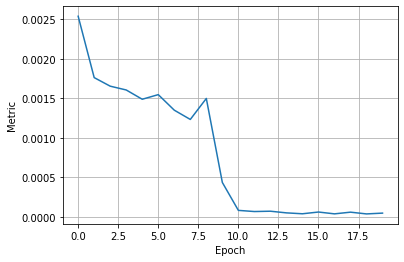

In [117]:
#!g1.1
history = defaultdict(list)
best_score = 100
best_epoch = 0 
for n in range(TaskConfig.num_epochs):

    train_dist_epoch(model, student, opt, train_loader,
                melspec_train, config_stud.device, 7)

    au_fa_fr = validation(student, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)

In [206]:
#!g1.1
for n in range(TaskConfig.num_epochs):

    train_dist_epoch(model, student, opt, train_loader,
                melspec_train, config_stud.device, 7)

    au_fa_fr = validation(student, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)

  0%|          | 0/405 [07:03<?, ?it/s]


KeyboardInterrupt: 

In [118]:
#!g1.1
validation(student, val_loader, melspec_val, config_stud.device)

102it [00:07, 14.09it/s]


4.7179431176348345e-05

In [120]:
#!g1.1
state = student.state_dict()
torch.save(state, 'model3.pt')

In [121]:
#!g1.1
print('size rate', SIZE / get_size_in_megabytes(student))
macs, _ = profile(student, (batch, ))
print('macs rate', MACS_CNT / macs )

size rate 6.717002377079945
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
macs rate 8.07675938025014


## Model 4


In [38]:
#!c1.8
def train_dist_epoch(teacher, student, opt, loader, log_melspec, device, temp, shedulder=None):
    student.train()
    teacher.eval()
    
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        with torch.no_grad():
            logits_teach = teacher(batch) / temp
            probs_teach = F.softmax(logits_teach, dim=-1)
        logits_stud = student(batch) / temp
        log_probs_stud = F.log_softmax(logits_stud, dim=-1)
        
        loss1 = F.kl_div(log_probs_stud, probs_teach, log_target=False)
        loss2 = F.cross_entropy(logits_stud, labels)
        
        loss = loss1 + loss2

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()
        if shedulder:
            shedulder.step()

        # logging
        argmax_probs = torch.argmax(log_probs_stud, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc


In [30]:
#!c1.8
def train_dist_epoch(teacher, student, opt, loader, log_melspec, device, temp, shedulder=None):
    student.train()
    teacher.eval()
    
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        with torch.no_grad():
            logits_teach = teacher(batch) #/ temp
            probs_teach = F.softmax(logits_teach, dim=-1)
        logits_stud = student(batch) #/ temp
        log_probs_stud = F.log_softmax(logits_stud, dim=-1)
        
        #loss1 = F.kl_div(log_probs_stud, probs_teach, log_target=False)
        #loss2 = F.cross_entropy(logits_stud, labels)
        
        #loss = loss1 + loss2
        loss = F.mse_loss(logits_teach, logits_stud)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()
        if shedulder:
            shedulder.step()

        # logging
        argmax_probs = torch.argmax(log_probs_stud, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc


In [31]:
#!c1.8
config_stud = TaskConfig(cnn_out_channels=3, hidden_size = 14, gru_num_layers = 2)
setup_seed(228)
student = CRNN(config_stud).to(config_stud.device)
print('size rate', SIZE / get_size_in_megabytes(student))
macs, _ = profile(student, (batch, ))
print('macs rate', MACS_CNT / macs )
_ = student(batch)

size rate 4.621927844273118
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
macs rate 3.930023434519592


In [32]:
#!c1.8
batch_inp = batch.unsqueeze(dim=1)
macs_conv, _ = profile(student.conv, (batch_inp, ))
batch_conv = student.conv(batch_inp).transpose(-1, -2)
macs_gru, _ = profile(student.gru, (batch_conv, ))
batch_gru, _ = student.gru(batch_conv)
macs_attent, _ = profile(student.attention, (batch_gru, ))
batch_attent = student.attention(batch_gru)
macs_class, _ = profile(student.classifier, (batch_attent, ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


In [33]:
#!c1.8
opt = torch.optim.Adam(
    student.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
sum([p.numel() for p in student.parameters()])

4758

In [423]:
#!c1.8
shedulder = None# torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=5e-3, epochs=60, steps_per_epoch=len(train_loader), pct_start=0.2)

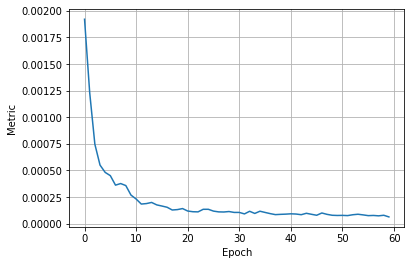

BEST SCORE: 6.43958059478845e-05
BEST EPOCH: 59
END OF EPOCH 59


In [434]:
#!c1.8
history = defaultdict(list)
best_score = 100
best_epoch = 0 
setup_seed(228)

for n in range(60):

    train_dist_epoch(model, student, opt, train_loader,
                melspec_train, config_stud.device, 7, shedulder)

    au_fa_fr = validation(student, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)

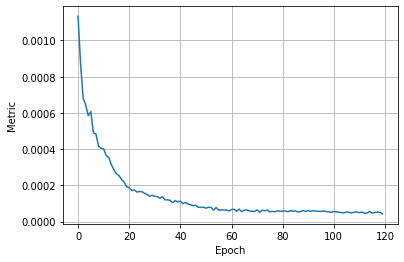

BEST SCORE: 4.235168518322086e-05
BEST EPOCH: 59
END OF EPOCH 59


In [425]:
#!c1.8
for n in range(60):

    train_dist_epoch(model, student, opt, train_loader,
                melspec_train, config_stud.device, 7, shedulder)

    au_fa_fr = validation(student, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)

In [429]:
#!c1.8
validation(student, val_loader, melspec_val, config_stud.device)

102it [00:08, 11.97it/s]


4.235168518322086e-05

In [427]:
#!c1.8
state = student.state_dict()
torch.save(state, '14_hidden.pt')

In [34]:
#!c1.8
ckpt = torch.load('14_hidden.pt', map_location=torch.device('cpu'))
student.load_state_dict(ckpt)

<All keys matched successfully>

In [35]:
#!c1.8
validation(student, val_loader, melspec_val, config_stud.device)

102it [00:12,  8.27it/s]


1.3253923177671346e-05

# Model 5


Здесь я использовал разные модели в качестве учителей

In [30]:
#!c1.8
config_model = TaskConfig(cnn_out_channels=3, hidden_size = 14, gru_num_layers = 2,)
model = CRNN(config_model).to(config_model.device)
print('size rate', SIZE / get_size_in_megabytes(model))
macs, _ = profile(model, (batch, ))
print('macs rate', MACS_CNT / macs )
_ = model(batch)
ckpt = torch.load('14_hidden.pt', map_location=torch.device('cpu'))
model.load_state_dict(ckpt)

size rate 4.621927844273118
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
macs rate 3.930023434519592


<All keys matched successfully>

In [31]:
#!c1.8
config_model = TaskConfig(cnn_out_channels=3, hidden_size = 12, kernel_size=(4, 20), stride=(2, 14))
model = CRNN(config_model).to(config_model.device)
print('size rate', SIZE / get_size_in_megabytes(model))
macs, _ = profile(model, (batch, ))
print('macs rate', MACS_CNT / macs )
_ = model(batch)
ckpt = torch.load('super.pt', map_location=torch.device('cpu'))
model.load_state_dict(ckpt)

size rate 5.351334023770775
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
macs rate 8.605250596658712


<All keys matched successfully>

In [29]:
#!c1.8
config_model = TaskConfig(cnn_out_channels=3, hidden_size = 10, kernel_size=(4, 18), stride=(2, 14))
model = CRNN(config_model).to(config_model.device)
print('size rate', SIZE / get_size_in_megabytes(model))
macs, _ = profile(model, (batch, ))
print('macs rate', MACS_CNT / macs )
_ = model(batch)
ckpt = torch.load('megasuper1.pt', map_location=torch.device('cpu'))
model.load_state_dict(ckpt)

size rate 6.450805540693181
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
macs rate 10.174771893518955


<All keys matched successfully>

In [31]:
#!c1.8
config_stud = TaskConfig(cnn_out_channels=3, hidden_size = 8, kernel_size=(4, 18), stride=(2, 14))
setup_seed(42)
student = CRNN(config_stud).to(config_stud.device)
print('size rate', SIZE / get_size_in_megabytes(student))
macs, _ = profile(student, (batch, ))
print('macs rate', MACS_CNT / macs )
_ = student(batch)

size rate 7.747875758657623
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
macs rate 11.390901432181971


Тут же код для обучения поэтапно, в начале обучаем классификатор, и так, постепенно к началу модели

In [32]:
#!c1.8
class Teacher(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(10, 8)
        self.decoder = nn.Linear(8, 10)
        
    def forward(self, x):
        size = x.size()
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [33]:
#!c1.8
def train_teach_epoch(teacher, model, opt, loader, log_melspec, device):
    teacher.train()
    model.eval()
    loss_mean = 0
    
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()
        
        with torch.no_grad():
            batch = batch.unsqueeze(dim=1)
            conv_output = model.conv(batch).transpose(-1, -2)
            batch_gru, _ = model.gru(conv_output)
            batch_attent = model.attention(batch_gru)
            
        preds = teacher(batch_attent)
        loss = F.mse_loss(preds, batch_attent)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(teacher.parameters(), 5)

        opt.step()
        loss_mean += loss.item()

    return loss_mean / len(loader)

In [34]:
#!c1.8
@torch.no_grad()
def validation_teach(teach, model, loader, log_melspec, device):
    model.eval()
    teach.eval

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)
        
        batch = batch.unsqueeze(dim=1)
        conv_output = model.conv(batch).transpose(-1, -2)
        batch_gru, _ = model.gru(conv_output)
        batch_attent = model.attention(batch_gru)
        batch_attent = teach(batch_attent)
        output = model.classifier(batch_attent)

        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [35]:
#!c1.8
setup_seed(42)
teach = Teacher()
opt = torch.optim.Adam(
    teach.parameters(),
    lr=3e-4,
)

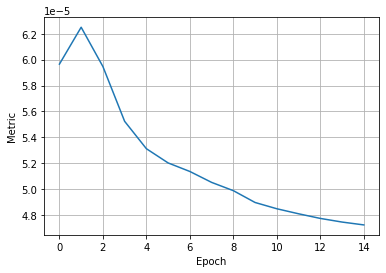

BEST SCORE: 4.7245074199740684e-05
BEST EPOCH: 14
END OF EPOCH 14


In [36]:
#!c1.8
history = defaultdict(list)
best_score = 100
best_epoch = 0 
setup_seed(42)

for n in range(15):

    train_teach_epoch(teach, model, opt, train_loader,
                melspec_train, config_stud.device)

    au_fa_fr = validation_teach(teach, model, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n
        
        state = teach.state_dict()
        torch.save(state, 'super_teach_class8.pt')

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)

In [37]:
#!c1.8
ckpt = torch.load('super_teach_class8.pt', map_location=torch.device('cpu'))
teach.load_state_dict(ckpt)

<All keys matched successfully>

In [38]:
#!c1.8
validation_teach(teach, model, val_loader,
                          melspec_val, config_stud.device)

102it [00:02, 35.44it/s]


4.7245074199740684e-05

In [39]:
#!c1.8
def train_teach_stud_epoch(teacher, student, model, opt, loader, log_melspec, device):
    student.train()
    teacher.eval()
    model.eval()
    loss_mean = 0
    
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()
        
        with torch.no_grad():
            batch = batch.unsqueeze(dim=1)
            conv_output = model.conv(batch).transpose(-1, -2)
            batch_gru, _ = model.gru(conv_output)
            batch_attent = model.attention(batch_gru)
            batch_attent = teach.encoder(batch_attent)
            output = model.classifier(teach.decoder(batch_attent))
            
        preds = student.classifier(batch_attent)
        loss = F.mse_loss(preds, output)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.conv.parameters(), 5)

        opt.step()
        loss_mean += loss.item()

    return loss_mean / len(loader)

In [40]:
#!c1.8
@torch.no_grad()
def validation_teach_student(teach, student, model, loader, log_melspec, device):
    model.eval()
    teach.eval()
    student.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        #output = model(batch)
        #
        batch = batch.unsqueeze(dim=1)
        conv_output = model.conv(batch).transpose(-1, -2)
        batch_gru, _ = model.gru(conv_output)
        batch_attent = model.attention(batch_gru)
        batch_attent = teach.encoder(batch_attent)
        output = student.classifier(batch_attent)
        #output = model.classifier(teach.decoder(batch_attent))    
        #
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [41]:
#!c1.8
opt_class = torch.optim.Adam(
    student.classifier.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

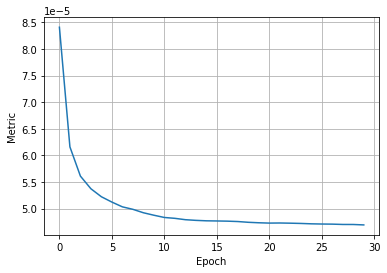

0.0011491341418978565
BEST SCORE: 4.691387530898842e-05
BEST EPOCH: 29
END OF EPOCH 29


In [42]:
#!c1.8
history = defaultdict(list)
best_score = 100
best_epoch = 0 
setup_seed(42)

for n in range(30):

    loss = train_teach_stud_epoch(teach, student, model, opt_class, train_loader,
                melspec_train, config_stud.device)

    au_fa_fr = validation_teach_student(teach, student, model, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n
        
        state = student.classifier.state_dict()
        torch.save(state, 'super_class8.pt')

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(loss)
    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)

In [43]:
#!c1.8
ckpt = torch.load('super_class8.pt', map_location=torch.device('cpu'))
student.classifier.load_state_dict(ckpt)

<All keys matched successfully>

### Attention


In [44]:
#!c1.8
def train_teach_attent_epoch(teacher, model, opt, loader, log_melspec, device):
    teacher.train()
    model.eval()
    loss_mean = 0
    
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()
        
        with torch.no_grad():
            batch = batch.unsqueeze(dim=1)
            conv_output = model.conv(batch).transpose(-1, -2)
            batch_gru, _ = model.gru(conv_output)
            
        preds = teacher(batch_gru)
        loss = F.mse_loss(preds, batch_gru)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(teacher.parameters(), 5)

        opt.step()
        loss_mean += loss.item()

    return loss_mean / len(loader)

In [45]:
#!c1.8
@torch.no_grad()
def validation_teach_attent(teach, model, loader, log_melspec, device):
    model.eval()
    teach.eval

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)
        
        batch = batch.unsqueeze(dim=1)
        conv_output = model.conv(batch).transpose(-1, -2)
        batch_gru, _ = model.gru(conv_output)
        batch_gru = teach(batch_gru)
        batch_attent = model.attention(batch_gru)
        output = model.classifier(batch_attent)

        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)
        
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [46]:
#!c1.8
setup_seed(42)
teach_attent = Teacher()
opt = torch.optim.Adam(
    teach_attent.parameters(),
    lr=3e-4,
)

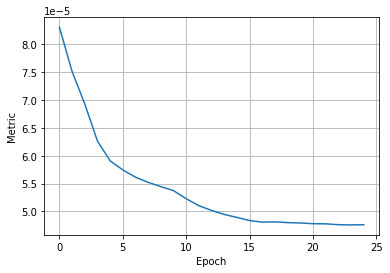

BEST SCORE: 4.7594175733236304e-05
BEST EPOCH: 23
END OF EPOCH 24


In [47]:
#!c1.8
history = defaultdict(list)
best_score = 100
best_epoch = 0 
setup_seed(228)

for n in range(25):
    train_teach_attent_epoch(teach_attent, model, opt, train_loader,
                melspec_train, config_stud.device)

    au_fa_fr = validation_teach_attent(teach_attent, model, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n
        
        state = teach_attent.state_dict()
        torch.save(state, 'teach_attent8.pt')

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)

In [48]:
#!c1.8
teach_class = Teacher()
ckpt = torch.load('super_teach_class8.pt')
teach_class.load_state_dict(ckpt)

<All keys matched successfully>

In [49]:
#!c1.8
ckpt = torch.load('super_class8.pt')
student.classifier.load_state_dict(ckpt)

<All keys matched successfully>

In [50]:
#!c1.8
ckpt = torch.load('teach_attent8.pt')
teach_attent.load_state_dict(ckpt)

<All keys matched successfully>

In [51]:
#!c1.8
def train_teach_stud_epoch_attent(teach_attent, teach_class, student, model, opt, loader, log_melspec, device):
    student.train()
    teach_attent.eval()
    teach_class.eval()
    model.eval()
    loss_mean = 0
    
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()
        
        with torch.no_grad():
            batch = batch.unsqueeze(dim=1)
            conv_output = model.conv(batch).transpose(-1, -2)
            batch_gru, _ = model.gru(conv_output)
            attent = model.attention(batch_gru)
            output = teach_class.encoder(attent)
            
        preds = student.attention(teach_attent.encoder(batch_gru))
        loss = F.mse_loss(preds, output)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.conv.parameters(), 5)

        opt.step()
        loss_mean += loss.item()

    return loss_mean / len(loader)

In [52]:
#!c1.8
@torch.no_grad()
def validation_teach_student_attent(teach_attent, student, model, loader, log_melspec, device):
    model.eval()
    teach_attent.eval()
    student.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        #output = model(batch)
        #
        batch = batch.unsqueeze(dim=1)
        conv_output = model.conv(batch).transpose(-1, -2)
        batch_gru, _ = model.gru(conv_output)
        batch_gru = teach_attent.encoder(batch_gru)
        batch_attent = student.attention(batch_gru)
        output = student.classifier(batch_attent)

        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [53]:
#!c1.8
opt_attent = torch.optim.Adam(
    student.attention.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

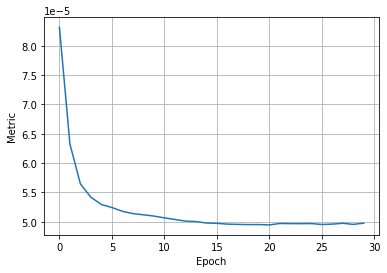

0.022766255433578967
BEST SCORE: 4.94470992571746e-05
BEST EPOCH: 20
END OF EPOCH 29


In [54]:
#!c1.8
history = defaultdict(list)
best_score = 100
best_epoch = 0 
setup_seed(42)

for n in range(30):

    loss = train_teach_stud_epoch_attent(teach_attent, teach_class, student, model, opt_attent, train_loader,
                melspec_train, config_stud.device)

    au_fa_fr = validation_teach_student_attent(teach_attent, student, model, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n
        
        state = student.attention.state_dict()
        torch.save(state, 'super_attent8.pt')

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(loss)
    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)

In [56]:
#!c1.8
ckpt = torch.load('super_attent8.pt')
student.attention.load_state_dict(ckpt)

<All keys matched successfully>

### Add teaching


Тут хотел использовать дообучения конца модели на обычном лоссе, но не успел


In [59]:
#!c1.8
def train_teach_full_epoch_attent(teach_attent, student, model, opt, loader, log_melspec, device, temp):
    student.train()
    model.eval()
    loss_mean = 0
    
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()
        
        with torch.no_grad():
            true_logits = model(batch) / temp
            batch = batch.unsqueeze(dim=1)
            conv_output = model.conv(batch).transpose(-1, -2)
            batch_gru, _ = model.gru(conv_output)
            batch_gru = teach_attent.encoder(batch_gru)
            
        batch_attent = student.attention(batch_gru)
        output = student.classifier(batch_attent) / temp
        loss = F.cross_entropy(output, F.softmax(true_logits, dim=-1) )
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()
        loss_mean += loss.item()

    return loss_mean / len(loader)

In [60]:
#!c1.8
@torch.no_grad()
def validation_teach_student_attent(teach_attent, student, model, loader, log_melspec, device):
    model.eval()
    teach_attent.eval()
    student.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        #output = model(batch)
        #
        batch = batch.unsqueeze(dim=1)
        conv_output = model.conv(batch).transpose(-1, -2)
        batch_gru, _ = model.gru(conv_output)
        batch_gru = teach_attent.encoder(batch_gru)
        batch_attent = student.attention(batch_gru)
        output = student.classifier(batch_attent)

        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [61]:
#!c1.8
opt_add = torch.optim.Adam(
    list(student.attention.parameters()) + list(student.classifier.parameters()),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

In [62]:
#!c1.8
history = defaultdict(list)
best_score = 100
best_epoch = 0 
setup_seed(42)

for n in range(30):

    loss = train_teach_full_epoch_attent(teach_attent, student, model, opt_add, train_loader,
                melspec_train, config_stud.device, 7)

    au_fa_fr = validation_teach_student_attent(teach_attent, student, model, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n
        
        state = student.state_dict()
        torch.save(state, 'student_nogru8.pt')

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(loss)
    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)

  0%|          | 0/404 [00:00<?, ?it/s]


RuntimeError: 1D target tensor expected, multi-target not supported

### GRU


In [57]:
#!c1.8
def train_teach_stud_epoch_gru(teach_attent, student, model, opt, loader, log_melspec, device):
    student.train()
    teach_attent.eval()
    model.eval()
    loss_mean = 0
    
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()
        
        with torch.no_grad():
            batch = batch.unsqueeze(dim=1)
            conv_output = model.conv(batch).transpose(-1, -2)
            batch_gru, _ = model.gru(conv_output)
            output = teach_attent.encoder(batch_gru)
            
        preds, _ = student.gru(conv_output)
        loss = F.mse_loss(preds, output)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.conv.parameters(), 5)

        opt.step()
        loss_mean += loss.item()

    return loss_mean / len(loader)

In [58]:
#!c1.8
@torch.no_grad()
def validation_teach_student_gru(student, model, loader, log_melspec, device):
    model.eval()
    teach_attent.eval()
    student.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        #output = model(batch)
        #
        batch = batch.unsqueeze(dim=1)
        conv_output = model.conv(batch).transpose(-1, -2)
        batch_gru, _ = student.gru(conv_output)
        batch_attent = student.attention(batch_gru)
        output = student.classifier(batch_attent)

        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [59]:
#!c1.8
opt_gru = torch.optim.Adam(
    student.gru.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

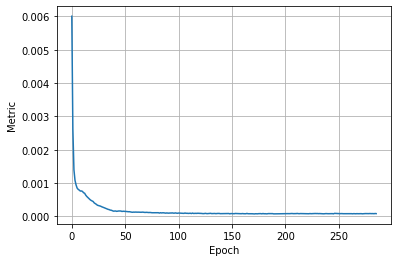

0.03379352580258014
BEST SCORE: 7.62891282770601e-05
BEST EPOCH: 171
END OF EPOCH 285


 87%|████████▋ | 352/404 [00:46<00:06,  7.57it/s]


KeyboardInterrupt: 

In [60]:
#!c1.8
history = defaultdict(list)
best_score = 100
best_epoch = 0 
setup_seed(42)

for n in range(300):

    loss = train_teach_stud_epoch_gru(teach_attent, student, model, opt_gru, train_loader,
                melspec_train, config_stud.device)

    au_fa_fr = validation_teach_student_gru(student, model, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n
        
        state = student.gru.state_dict()
        torch.save(state, 'super_gru10.pt')

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(loss)
    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)

Эхх, а могла бы выйти модель чисто на 10...

### Reproduce

In [ ]:
history = defaultdict(list)
config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

In [ ]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
history